In [1]:
import bulwark.checks as ck
import pandas as pd

import seaborn as sns
MICHAEL_1_DAY_NBR = 15
ATTACK_TITSEY = 44 # attacked by another dog
pd.to_datetime("2020-05-01") + pd.Timedelta(days=46)

Timestamp('2020-06-16 00:00:00')

In [2]:
df_raw = pd.read_excel('Ada dog encounters.ods', engine='odf')
df_raw.head()

,Date,Location,Ada lead? y/n,They lead? y/n,Their distance m,Their breed,Their age years,Their colour,Good? g/b,Name,Their temprament,Notes
0,2020-05-01,frontgarden,y,y,5,mongrel,17.0,black,b,Leo,NaN,9pm dark
1,2020-05-02,frontgarden,y,y,5,mongrel,17.0,black,g,Leo,NaN,"9pm dark, better"
2,2020-05-04,bpp,y,n,0,colliedoodle,1.0,black,g,NaN,NaN,great play
3,2020-05-04,bpp,y,n,0,cockerpoo,1.0,brown,g,NaN,NaN,NaN
4,2020-05-04,bpp,y,n,0,french bulldog,3.0,grey,b,NaN,NaN,initial good sniff then ada snapped


In [3]:
df_raw.Date.describe()

count                      66
unique                     51
top       2020-05-05 00:00:00
freq                        7
first     2020-05-01 00:00:00
last      2020-06-24 00:00:00
Name: Date, dtype: object

In [4]:
df_raw.tail()

,Date,Location,Ada lead? y/n,They lead? y/n,Their distance m,Their breed,Their age years,Their colour,Good? g/b,Name,Their temprament,Notes
269,NaT,NaN,NaN,NaN,0,labrador,3.0,black,b,NaN,NaN,"calm but his buddy, small terrier, came tearin..."
270,NaT,well wood,y,y,0,retriever,3.0,black,g,NaN,NaN,light play
271,NaT,NaN,NaN,n,0,jack russel,5.0,white,g,NaN,high energy,Ada calm
272,NaT,NaN,NaN,y,0,labrador,3.0,black,g,NaN,nervous,light play
273,NaT,NaN,y,y,4,staffie,5.0,brown,b,NaN,pully,"he pulled into car park at Ada, she lunged"


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              66 non-null     datetime64[ns]
 1   Location          135 non-null    object        
 2   Ada lead? y/n     196 non-null    object        
 3   They lead? y/n    207 non-null    object        
 4   Their distance m  274 non-null    int64         
 5   Their breed       274 non-null    object        
 6   Their age years   178 non-null    float64       
 7   Their colour      254 non-null    object        
 8   Good? g/b         274 non-null    object        
 9   Name              9 non-null      object        
 10  Their temprament  66 non-null     object        
 11  Notes             157 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 25.8+ KB


In [6]:
# forward fill missing items due to lazy entry
#df_raw['Location'] = df_raw['Location'].ffill()
#df_raw['Date'] = df_raw.Date.ffill()

def ffill_col(df_raw, col, strip=False):
    df_raw[col] = df_raw[col].ffill()
    if strip:
        df_raw[col] = df_raw[col].str.strip()
    
ffill_col(df_raw, 'Location')
ffill_col(df_raw, 'Date')
ffill_col(df_raw, 'They lead? y/n')
ffill_col(df_raw, 'Ada lead? y/n')
ffill_col(df_raw, 'Good? g/b', strip=True)


In [7]:
df_raw['They lead? y/n'].value_counts(dropna=False)

n    144
y    130
Name: They lead? y/n, dtype: int64

In [8]:
# TEMPORARY FIX
#df_raw['They lead? y/n'] = df_raw['They lead? y/n'].replace('b', 'y')
# TEMPORARY FIX
#df_raw['Good? g/b'] = df_raw['Good? g/b'].replace('?', 'b')

In [9]:
#df_raw['Good? g/b'] = df_raw['Good? g/b'].replace('g ', 'g')
df_raw['Good? g/b'].value_counts(dropna=False).keys()

Index(['g', 'b'], dtype='object')

In [10]:
df_raw['Ada lead? y/n'].value_counts(dropna=False)

y    261
n     13
Name: Ada lead? y/n, dtype: int64

In [11]:
def clean_yn_column(df_raw, col_from, col_to, item_true, item_false):
    print(df_raw[col_from].value_counts())

    assert df_raw[col_from].isin(set([item_true, item_false])).all()
    df_raw[col_to] = df_raw[col_from] == item_true
    df_raw = df_raw.drop(columns=[col_from])
    return df_raw
    
set_y_n = set(['y', 'n'])
col_from = 'Ada lead? y/n'
col_to = 'ada_lead'
df_raw = clean_yn_column(df_raw, col_from, col_to, "y", "n")

col_from = 'They lead? y/n'
col_to = 'they_lead'
df_raw = clean_yn_column(df_raw, col_from, col_to, "y", "n")

col_from = 'Good? g/b'
col_to = 'was_good'
df_raw = clean_yn_column(df_raw, col_from, col_to, "g", "b")

y    261
n     13
Name: Ada lead? y/n, dtype: int64
n    144
y    130
Name: They lead? y/n, dtype: int64
g    210
b     64
Name: Good? g/b, dtype: int64


In [12]:
df_raw = df_raw.rename(columns={'Location': 'location', 'Their distance m': 'distance_m',
                       'Their colour': 'colour', 'Their age years': 'age_y',
                               'Their breed': 'breed',})
                                #'Date': 'Date_str'})

In [13]:
#df_raw['Date'] = pd.to_datetime(df_raw['Date_str'], yearfirst=True)
#df_raw['Date'] = df_raw['Date_']

In [14]:
df_raw.head()

,Date,location,distance_m,breed,age_y,colour,Name,Their temprament,Notes,ada_lead,they_lead,was_good
0,2020-05-01,frontgarden,5,mongrel,17.0,black,Leo,NaN,9pm dark,True,True,False
1,2020-05-02,frontgarden,5,mongrel,17.0,black,Leo,NaN,"9pm dark, better",True,True,True
2,2020-05-04,bpp,0,colliedoodle,1.0,black,NaN,NaN,great play,True,False,True
3,2020-05-04,bpp,0,cockerpoo,1.0,brown,NaN,NaN,NaN,True,False,True
4,2020-05-04,bpp,0,french bulldog,3.0,grey,NaN,NaN,initial good sniff then ada snapped,True,False,False


In [15]:
df = df_raw.copy()

In [16]:
df.shape

(274, 12)

In [17]:
df['day_nbr'] = (df.Date - df.Date.min()).dt.days

In [18]:
df = df.sort_values('Date')
df.tail()

,Date,location,distance_m,breed,age_y,colour,Name,Their temprament,Notes,ada_lead,they_lead,was_good,day_nbr
272,2020-06-24,well wood,0,labrador,3.0,black,NaN,nervous,light play,True,True,True,54
268,2020-06-24,harvington,0,cocker,3.0,grey,NaN,NaN,NaN,True,True,True,54
267,2020-06-24,harvington,0,greyhound,NaN,black,NaN,NaN,NaN,True,True,True,54
269,2020-06-24,harvington,0,labrador,3.0,black,NaN,NaN,"calm but his buddy, small terrier, came tearin...",True,True,False,54
273,2020-06-24,well wood,4,staffie,5.0,brown,NaN,pully,"he pulled into car park at Ada, she lunged",True,True,False,54


# Checks

* could check for monotonic increases?

In [19]:
ck.is_monotonic(df[['Date']]);
def always_gte_zero(df):
    """Check we're always positive"""
    assert (df >= 0).all().all()
    
ck.custom_check(df[['distance_m']], always_gte_zero);
#ck.custom_check(df[['age_y']], always_gte_zero);

TypeError: Invalid comparison between dtype=timedelta64[ns] and int

In [20]:
df.describe().style.background_gradient(axis=0)

,distance_m,age_y,day_nbr
count,274.000000,178.000000,274.000000
mean,2.364964,4.342697,28.697080
std,3.758996,3.378309,16.449485
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,13.000000
50%,0.000000,3.000000,27.500000
75%,4.000000,5.000000,46.000000
max,25.000000,17.000000,54.000000


# Analysis

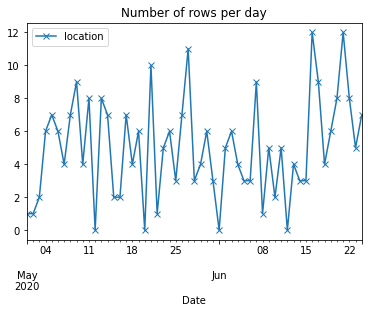

In [21]:
ax = df.set_index('Date')[['location']].resample('d').count().plot(marker='x')
ax.set_title('Number of rows per day');

Some suggestion that closer means less good

In [22]:
df.groupby('was_good').agg({'distance_m': 'median', 'age_y': 'median'})

,distance_m,age_y
was_good,,
False,2,3.0
True,0,3.0


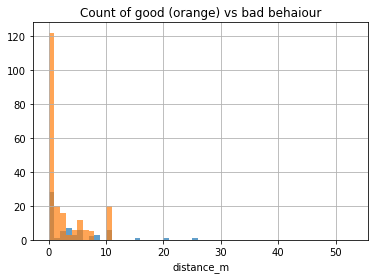

In [23]:
# TODO FIX THIS, IT LOOKS WEIRD!

# was_good False is blue
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
nbr_days = df.day_nbr.max()
df.groupby('was_good')['distance_m'].hist(alpha=0.7, ax=ax, bins=range(0, nbr_days, 1));
ax.set_xlabel('distance_m')
ax.set_title('Count of good (orange) vs bad behaiour');

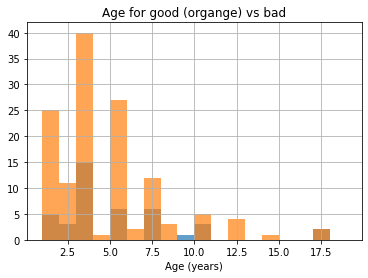

In [24]:
fig, ax = plt.subplots()
df.groupby('was_good')['age_y'].hist(alpha=0.7, bins=range(1, 20, 1), ax=ax);
ax.set_title("Age for good (organge) vs bad")
ax.set_xlabel('Age (years)');

Some suggestion that black is the worst colour (but black is also the best colour!)

In [25]:
df.groupby(['was_good', 'colour'])['location'].count().unstack().fillna(0)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0.0,0.0,0.0,18.0,1.0,0.0,18.0,0.0,14.0,1.0,0.0,8.0,1.0
True,1.0,1.0,1.0,49.0,1.0,1.0,65.0,2.0,43.0,0.0,1.0,28.0,0.0


In [26]:
pd.crosstab(index=df['was_good'], columns=df['colour']). \
style.background_gradient(axis=1)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0,0,0,18,1,0,18,0,14,1,0,8,1
True,1,1,1,49,1,1,65,2,43,0,1,28,0


In [27]:
pd.crosstab(index=df['was_good'], columns=df['colour'], normalize=0). \
style.background_gradient(axis=1)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0.000000,0.000000,0.000000,0.295082,0.016393,0.000000,0.295082,0.000000,0.229508,0.016393,0.000000,0.131148,0.016393
True,0.005181,0.005181,0.005181,0.253886,0.005181,0.005181,0.336788,0.010363,0.222798,0.000000,0.005181,0.145078,0.000000


In [28]:
pd.crosstab(index=df['was_good'], columns=df['colour'], normalize="columns"). \
style.background_gradient(axis=1)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0.000000,0.000000,0.000000,0.268657,0.500000,0.000000,0.216867,0.000000,0.245614,1.000000,0.000000,0.222222,1.000000
True,1.000000,1.000000,1.000000,0.731343,0.500000,1.000000,0.783133,1.000000,0.754386,0.000000,1.000000,0.777778,0.000000


In [29]:
pd.crosstab(index=df['was_good'], columns=df['colour'], normalize="all"). \
style.background_gradient(axis=1)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0.000000,0.000000,0.000000,0.070866,0.003937,0.000000,0.070866,0.000000,0.055118,0.003937,0.000000,0.031496,0.003937
True,0.003937,0.003937,0.003937,0.192913,0.003937,0.003937,0.255906,0.007874,0.169291,0.000000,0.003937,0.110236,0.000000


In [30]:
pd.crosstab(index=df['was_good'], columns=df['colour'], normalize="index"). \
style.background_gradient(axis=1)

colour,"2 dogs, one dark brown, one beige",beige,beige & white,black,black and white,blank,brown,golden,grey,grey black,light brown,white,white brown
was_good,,,,,,,,,,,,,
False,0.000000,0.000000,0.000000,0.295082,0.016393,0.000000,0.295082,0.000000,0.229508,0.016393,0.000000,0.131148,0.016393
True,0.005181,0.005181,0.005181,0.253886,0.005181,0.005181,0.336788,0.010363,0.222798,0.000000,0.005181,0.145078,0.000000


In [31]:
pd.crosstab(index=df['was_good'], columns=df['location'], margins=False, normalize=False). \
style.background_gradient(axis=1)

location,BPP,Croydon rec,Kelsey,Spring Park,Well Wood,backyard,bpp,clissold,downe,frifh,frifth,frontgarden,harvington,helen sitter,high elms,highbroom,jubilee park,kelsey,keston,kings wood,porch,spring park,stanhope,stanhope rec,street,sydenham hill wood,titsey,well wood,wood
was_good,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,3,0,1,1,0,22,0,0,0,0,3,11,0,1,0,0,0,0,0,0,3,0,0,14,0,1,2,1
True,6,8,4,0,0,1,79,1,1,1,2,6,45,1,1,1,1,3,3,6,1,0,1,1,27,6,0,4,0


In [32]:
# can sort with [::-1]
df.groupby(['was_good', 'location'])[['location']].count().unstack(0).fillna(0)

location      
was_good              False True 
location                         
BPP                     1.0   6.0
Croydon rec             3.0   8.0
Kelsey                  0.0   4.0
Spring Park             1.0   0.0
Well Wood               1.0   0.0
backyard                0.0   1.0
bpp                    22.0  79.0
clissold                0.0   1.0
downe                   0.0   1.0
frifh                   0.0   1.0
frifth                  0.0   2.0
frontgarden             3.0   6.0
harvington             11.0  45.0
helen sitter            0.0   1.0
high elms               1.0   1.0
highbroom               0.0   1.0
jubilee park            0.0   1.0
kelsey                  0.0   3.0
keston                  0.0   3.0
kings wood              0.0   6.0
porch                   0.0   1.0
spring park             3.0   0.0
stanhope                0.0   1.0
stanhope rec            0.0   1.0
street                 14.0  27.0
sydenham hill wood      0.0   6.0
titsey                  1.0   0.0
well wood               2.0   4.0
wood                    1.0   0.0

In [ ]:
df.groupby(['was_good', 'location'])[['location']].size().nlargest(5).unstack(0)

In [ ]:
df

In [ ]:
pd.crosstab(index=df['was_good'], columns=df['breed'], margins=False, normalize=False). \
style.background_gradient(axis=1)

# some ideas

In [ ]:
# notes has missing days
count_by_day_nbr = df.groupby('day_nbr')['was_good'].count()
count_by_day_nbr.tail()

In [ ]:
good_bad_by_day_nbr = df.groupby(['day_nbr', 'was_good'])['location'].count().unstack(1).fillna(0).astype('int')
#pd.merge(left=count_by_day_nbr, right=good_bad_by_day_nbr, left_index=True, right_index=True)

In [ ]:
pct_good = good_bad_by_day_nbr[True] / count_by_day_nbr
pct_good = pct_good.reindex(index=range(good_bad_by_day_nbr.index.max()+1))

df_pct_good = pd.DataFrame(pct_good, columns=['pct_good'])
df_pct_good['observations'] = count_by_day_nbr

fig, ax = plt.subplots(figsize=(12, 8))
df_pct_good['pct_good'].plot(marker='x', linestyle=' ', ax=ax)
ax2 = ax.twinx()
df_pct_good['observations'].plot(ax=ax2, color='orange', alpha=0.5)
ax2.set_ylim(ymin=0)
ax2.set_ylabel("Observations per day")
ax.set_title('Percentage of daily good interactions')
ax.set_ylabel('Percentage of Good Interactions')
ax.set_xlabel('Day nbr');
ax.vlines(MICHAEL_1_DAY_NBR, 0, 1, colors='r', label='Michael') 
ax.vlines(ATTACK_TITSEY, 0, 1, colors='r', label='Ada attacked at Titsey')

ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
gpby = df.groupby('day_nbr')['distance_m'].median()
gpby.plot(marker='x', linestyle=' ', ax=ax)
ax.set_title("Median distance(m)");
ax.set_ylabel("Distance (m)")
ax.vlines(MICHAEL_1_DAY_NBR, 0, 10, colors='r', label='Michael')
ax.vlines(ATTACK_TITSEY, 0, 10, colors='r', label='Ada attacked at Titsey')

ax.legend();
plt.xticks(gpby.index, gpby.index, rotation=45);

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
col = 'distance_m'
sns.boxplot(data=df, x='day_nbr', y=col, ax=ax);
y_max = df[col].max()
ax.vlines(MICHAEL_1_DAY_NBR, 0, y_max, colors='r', label='Michael')

ax.vlines(ATTACK_TITSEY, 0, y_max, colors='r', label='Ada attacked at Titsey')
# BUGGY THIS NEEDS A FIX!
#ax.axvline(x=ATTACK_TITSEY, kwargs={'label': 'Ada attacked at Titsey', 'colors':'r'})
ax.legend();
ax.set_title(f"Boxplot for {col}");